In [19]:
!pip install lime

#Imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.pipeline import make_pipeline
from sklearn.inspection import PartialDependenceDisplay
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [21]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [22]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#GMM-ASVM Classifier Model

In [ ]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_train_final)

X_train_gmm = gmm.predict_proba(X_train_final)
X_test_gmm = gmm.predict_proba(X_test_final)

X_train_aug = X_train_final.copy()
X_test_aug = X_test_final.copy()
X_train_aug['GMM_Cluster_0'] = X_train_gmm[:, 0]
X_train_aug['GMM_Cluster_1'] = X_train_gmm[:, 1]
X_test_aug['GMM_Cluster_0'] = X_test_gmm[:, 0]
X_test_aug['GMM_Cluster_1'] = X_test_gmm[:, 1]

feature_names = X_train_aug.columns.tolist()

In [38]:
svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', probability=True, random_state=42))
svm_model.fit(X_train_aug, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True, random_state=42))])


GMM-ASVM Evaluation
Accuracy: 0.93
Precision: 0.92
Recall: 0.95
F1 Score: 0.94
AUC: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       544
           1       0.92      0.95      0.94       635

    accuracy                           0.93      1179
   macro avg       0.93      0.93      0.93      1179
weighted avg       0.93      0.93      0.93      1179



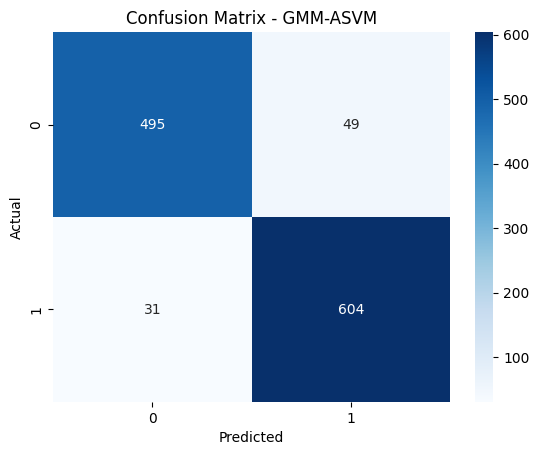

In [40]:
evaluate_model("GMM-ASVM", svm_model, X_test_aug, y_test)

#Lime for GMM-ASVM

In [29]:
sample_instance = X_test_aug.iloc[0]
explainer = LimeTabularExplainer(
    training_data=X_train_aug.values,
    feature_names=X_train_aug.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)

print("\nLIME Explanation for GMM-ASVM")
exp = explainer.explain_instance(
    data_row=sample_instance.values,
    predict_fn=svm_model.predict_proba
)
exp.show_in_notebook()



LIME Explanation for GMM-ASVM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


LIME explanation for the GMM-ASVM model prediction:

1-Churn Probability : 92%

2-No Churn Probability : 8%

->The model strongly predicts that the customer will churn .

->The most influential feature pushing the prediction toward churn is high MonthlyCostPerTenure (43.80), contributing 0.16 to the decision.

Additional churn indicators include:

    Lack of fiber optic internet service.

    Lack of additional services like online security, tech support, and device protection.

    High monthly costs relative to tenure.

    Short tenure with the company.

    Payment method being electronic check.

The model predicts high churn risk due to multiple negative service and payment factors. This customer lacks protective services and is paying a relatively high amount soon after joining, which likely contributes to dissatisfaction.



#PDP for GMM-ASVM


PDP - GMM-ASVM


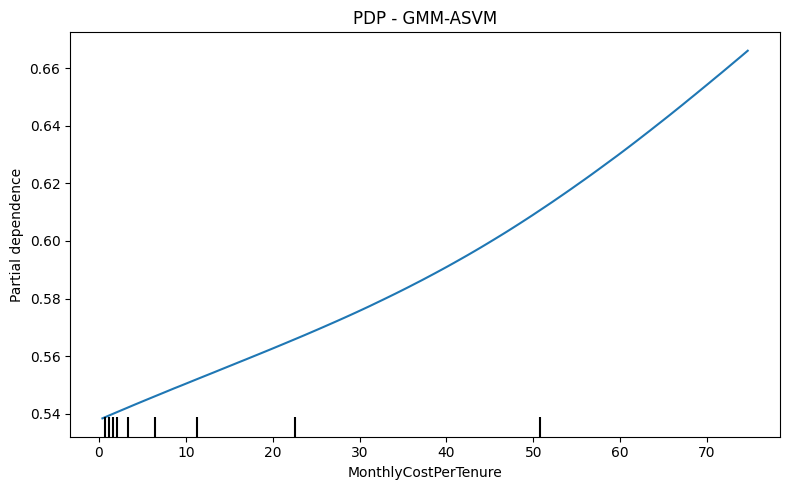

In [30]:
selected_feature = 'MonthlyCostPerTenure'
feature_index = X_train_aug.columns.tolist().index(selected_feature)

print("\nPDP - GMM-ASVM")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(svm_model, X_test_aug, [feature_index], ax=ax)
ax.set_title("PDP - GMM-ASVM")
plt.tight_layout()
plt.show()


->This PDP illustrates that MonthlyCostPerTenure has a strong positive relationship with the target variable.

->Customers with higher MonthlyCostPerTenure values are more likely to churn.

->The vertical bars indicate the distribution of this feature in the dataset showing that most customers have lower values but the trend holds consistently across the range.

->Higher MonthlyCostPerTenure is associated with a higher churn probability.

#ICE for GMM-ASVM

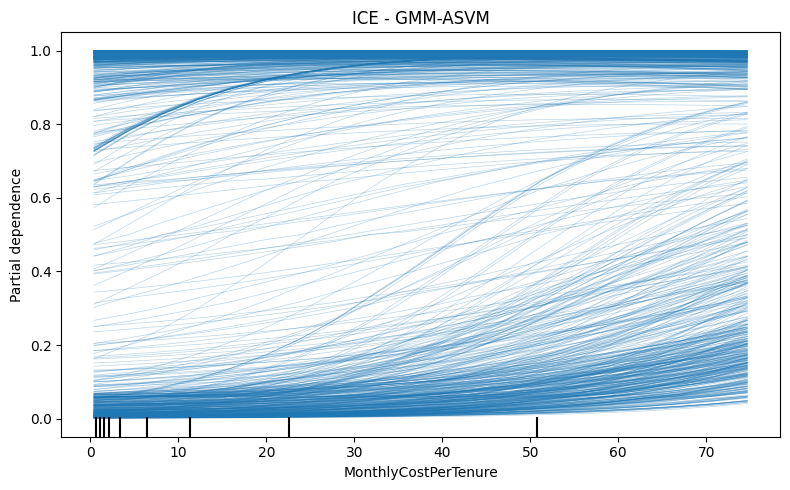

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(
    svm_model,
    X_test_aug,
    [feature_index],
    kind='individual',
    grid_resolution=20,
    ax=ax
)
ax.set_title("ICE - GMM-ASVM")
plt.tight_layout()
plt.show()


->This ICE plot illustrates that higher MonthlyCostPerTenure values are associated with a higher churn probability for most customers.

->The individual curves show consistency in this trend with some variability across different customers.

->The vertical bars indicate the distribution of the feature in the dataset, confirming that most customers have lower MonthlyCostPerTenure values.

->Higher MonthlyCostPerTenure is associated with a higher churn probability for most customers.

Comparasion between PDP and ICE:

->The PDP showed the average effect of MonthlyCostPerTenure on churn probability represented by a single line.

->The ICE plot provides a more detailed view by showing how the effect varies for individual customers .

Both plots confirm the positive relationship between MonthlyCostPerTenure and churn probabilit but the ICE plot offers additional insights into individual variability.

#Shap for GMM-ASVM


SHAP Summary for GMM-ASVM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ut

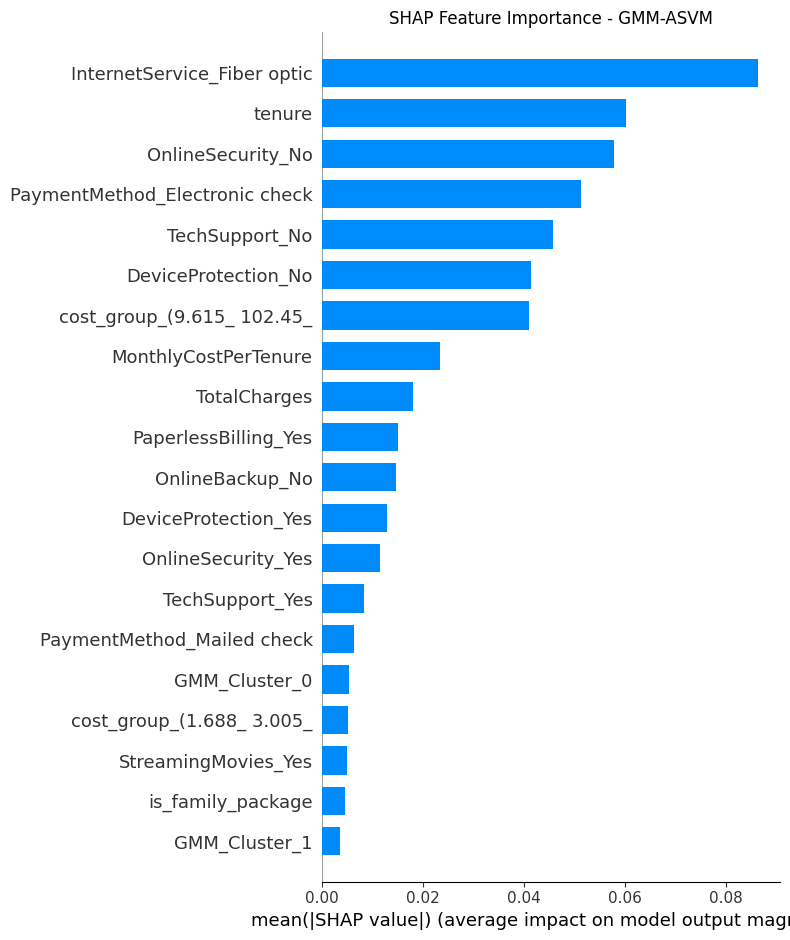

In [32]:
print("\nSHAP Summary for GMM-ASVM")
background = shap.sample(X_train_aug, 100, random_state=42)
predict_fn = lambda x: svm_model.predict_proba(x)[:, 1]
explainer_gmm = shap.KernelExplainer(predict_fn, background)
X_sample = X_test_aug.iloc[:100]
shap_values_gmm = explainer_gmm.shap_values(X_sample, nsamples="auto")
shap.summary_plot(shap_values_gmm, X_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - GMM-ASVM")
plt.tight_layout()
plt.show()

This SHAP feature importance plot highlights that InternetService_Fiber optic , tenure , OnlineSecurity_No , PaymentMethod_Electronic check , and TechSupport_No are the most important features for predicting customer churn in the GMM-ASVM model.

These features have the strongest impact on the model's predictions, while other features have progressively lesser importance.

High SHAP Values : Features with high mean absolute SHAP values ( InternetService_Fiber optic, tenure) have a strong impact on the model's predictions.

Low SHAP Values : Features with low mean absolute SHAP values ( GMM_Cluster_0, GMM_Cluster_1) have minimal impact on the model's predictions. These features may be less relevant or could be removed without significantly affecting the model's performance.

Comparasion between Lime and Shap:
  
LIME provides local explanations for individual instances, while SHAP offers global insights by summarizing feature importance across the entire dataset.